<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
</center>
Авторы материала: аспирант Мехмата МГУ Евгений Колмаков, программист-исследователь Mail.ru Group Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3. Опциональная часть 
## <center> Реализация алгоритма построения дерева решений

In [61]:
import math
import pandas as pd
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Зафиксируем заранее `random_state` (a.k.a. random seed). Это должно повысить вероятность полной воспроизводимости результатов, впрочем, замечено, что тем не менее небольшие флуктуации возможны (например, качества прогнозов дерева, которое мы сейчас вырастим) в случае разных ОС.

In [62]:
RANDOM_STATE = 17

**Необходимо реализовать класс `DecisionTree`**

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    `min_samples_split` - минимальное число объектов в вершине, при котором происходит её разбиение (по умолчанию - 2); 
    `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', для регрессии - 'variance' или 'mad_median'; 
    по умолчанию - 'gini');
    
    Функционал, значение которого максимизируется для поиска оптимального разбиения в данной вершине имеет вид
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    где $X$ - выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ - разбиение выборки $X$ на две части 
    по предикату $[x_j < t]$, а $F(X)$ -критерий разбиения.
    
    Для классификации: пусть $p_i$ - доля объектов $i$-го класса в выборке $X$.
    
    'gini': Неопределенность Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    Для регрессии: $y_j = y(x_j)$ - ответ на объекте $x_j$, $y = (y_1, \dots, y_{|X|})$ - вектор ответов.
    
    'variance': Дисперсия (среднее квадратичное отклонение от среднего) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Среднее отклонение от медианы $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- класс имеет методы `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `DecisionTree`, представляющий собой решающее дерево, обученное по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict_proba` принимает матрицу объектов `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - число классов, такую что $p_{ij}$ есть вероятность принадлежности объекта, заданного $i$-ой строкой матрицы X к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов; в случае классификации - это 
    наиболее многочисленный класс в листе, в который попал объект, а в случае регрессии - среднее значение ответов по 
    всем объектам этого листа;

In [63]:
#def entropy(y):    

def entropy(a_list):
    a_list=pd.Series(a_list)
    p_data= a_list.value_counts()/len(a_list) # calculates the probabilities
    entropy=sc.stats.entropy(p_data)  # input probabilities to get the entropy 
    return entropy # If only probabilities pk are given, the entropy is calculated as S = -sum(pk * log(pk), axis=0).

def information_gain(root, left, right): #root - initial data, left and right - two partitions of initial data
    ent0 = entropy(root)
    ent1 = entropy(left)
    ent2 = entropy(right)
    information_gain = ent0 - len(left)/len(root) * ent1 - len(right)/len(root) * ent2   
    return information_gain

In [64]:
def entropy1(a_list):
    ent = []
    n = set(a_list)
    for i in n:
        list_ = [x for x in a_list if x==i]
        entropy = -(len(list_) / len(a_list)) * math.log((len(list_) / len(a_list)),2)
        ent.append(entropy)                                                         
    return sum(ent)

print(entropy1([1,2,3,4,5,6]))
print(entropy([1,2,3,4,5,6]))

2.584962500721156
1.791759469228055


In [86]:
def gini(y):
    y=pd.Series(y)
    p_data= y.value_counts()/len(y)                                                     
    return 2*p_data.iloc[0]*(1-p_data.iloc[0])
    
print(gini([1,2,1,2,1,2]))

0.5


In [70]:
def variance(y):
    return np.var(y)

print(variance([1,2,3,4,5,6]))

2.9166666666666665


In [87]:
def mad_median(y):
    median = np.median(y)
    N = len(y)
    return sum(list(map(lambda x: abs(x - median), y))) / N
print(mad_median([1,2,3,4,5,6]))

1.5


In [47]:
def best_feature_to_split(X, y): #Outputs information gain when splitting on best feature
# X - input list, y - list of indexes of splitting
    for i in y:
        root = X
        left = X[0:i]
        right= X[(i+1):(-1)]
        information_gain(root, left, right)
    
    best_feature_to_split = max(information_gain(root, left, right))
    return best_feature_to_split

X = [1,2,3,1,2,3]
y = [0,1,2,3,4,5]
print (best_feature_to_split(X, y))

TypeError: 'float' object is not callable

In [ ]:
def tree (maxdepth, X, y): 
    for i in range(maxdepth):
        tree = []
        if i < 0:
            return "Maxdepth should be positive integer"
        elif i > len(X):
            return "Maxdepth should be less or is than length of features list"
        else:
            best = best_feature_to_split(X,y)
            tree.append(best)
    return tree 
X = [1,2,3,1,2,3]
y = [0,1,2,3,4,5]
print (tree (3,X,y))

In [16]:
class DecisionTree(BaseEstimator):
    
    def __init__(self, max_depth=np.inf, min_samples_split=2, 
                 criterion='gini', debug=False):
        pass
    
    def fit(self, X, y):
        pass
        
    def predict(self, X):
        pass
        
    def predict_proba(self, X):
        pass

## Тестирование реализованного алгоритма

### Классификация

С помощью метода `load_digits` загрузите датасет `digits`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие решающие деревья и убедитесь, что критерии gini и entropy дают разные результаты.

In [140]:
import pandas as pd
data = load_digits();
X,y=data.data, data.target;

In [141]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)
print(y)
print(X)

[0 1 2 ... 8 9 8]
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


In [142]:
tree1 = DecisionTreeClassifier(random_state=17, criterion = "gini")
tree1.fit(x_train, y_train)

from sklearn.model_selection import cross_val_score
np.mean(cross_val_score (tree1, x_test, y_test, cv=5))

0.7038051318973589

In [143]:
tree2 = DecisionTreeClassifier(random_state=17, criterion = "entropy")
tree2.fit(x_train, y_train)

from sklearn.model_selection import cross_val_score
np.mean(cross_val_score (tree2, x_test, y_test, cv=5))

0.7679401782613253

С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - range(3, 11), а для criterion - {'gini', 'entropy'}. Критерий качества `scoring`='accuracy'.

In [144]:
tree1_predictions = tree1.predict(x_test)

In [145]:
tree1_params = {"max_depth": range(3,11),
               "criterion": ["gini", "entropy"]}

best_tree = GridSearchCV(tree1, tree1_params, scoring="accuracy", cv=5, n_jobs=-1)
%time,
best_tree.fit(x_train, y_train)     
print("Best params:", best_tree.best_params_)
print("Best cross validaton score", best_tree.best_score_)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 11 µs
Best params: {'criterion': 'entropy', 'max_depth': 9}
Best cross validaton score 0.8684759916492694


In [155]:
#from sklearn.model_selection import grid_scores_
print(best_tree.cv_results_)

{'mean_fit_time': array([0.01043239, 0.01327443, 0.01462326, 0.01652904, 0.02174382,
       0.01870627, 0.02589707, 0.02070985, 0.01305761, 0.01630697,
       0.01870494, 0.02590418, 0.0156642 , 0.02143359, 0.01734009,
       0.01757302]), 'std_fit_time': array([0.00286463, 0.0032721 , 0.0035181 , 0.00313591, 0.006133  ,
       0.00109155, 0.00832188, 0.00117692, 0.00454518, 0.00466387,
       0.00194955, 0.00734356, 0.00108856, 0.00506215, 0.00092463,
       0.00219908]), 'mean_score_time': array([0.00117259, 0.00079074, 0.00052862, 0.00052075, 0.00055413,
       0.00074706, 0.00063896, 0.00056639, 0.00057449, 0.000665  ,
       0.00056696, 0.00052748, 0.00041275, 0.00043464, 0.0003952 ,
       0.00037079]), 'std_score_time': array([3.89479890e-04, 2.22756947e-04, 4.70318101e-05, 4.92943083e-05,
       3.01327130e-05, 3.73633654e-04, 1.14634767e-04, 9.53410351e-05,
       4.53518515e-05, 2.71255992e-04, 7.03337233e-05, 7.26336792e-05,
       5.64818394e-05, 6.73646200e-05, 2.00620982e

In [171]:
print(best_tree.cv_results_['mean_test_score'].astype("float"))
print(best_tree.cv_results_["param_max_depth"].astype("float"))
print(type(best_tree.cv_results_['param_criterion']))

[0.4815588  0.57063326 0.67084203 0.76270007 0.81628392 0.83855254
 0.84899095 0.84690327 0.53235908 0.67362561 0.77035491 0.82254697
 0.85107864 0.86290884 0.86847599 0.86012526]
[3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0]
<class 'numpy.ma.core.MaskedArray'>


Постройте графики средних значений критерия качества `accuracy` для критериев `gini` и `entropy` в зависимости от `max_depth`.

ValueError: could not convert string to float: '?'

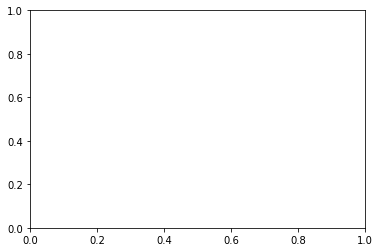

In [173]:
plt.rcParams['figure.figsize'] = (6,4) 

plt.plot(best_tree.cv_results_["param_max_depth"].astype("float"), 
         best_tree.cv_results_["mean_test_score"].astype("float"), label=best_tree.cv_results_['param_criterion'])
#plt.plot(maxdepth, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in maxdepth], label='entropy')

plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Comparing of gini & entropy')
plt.legend();

**Выберите верные утверждения:**
1. Оптимальное значение `max_depth` для каждого критерия достигается на отрезке [4, 9].
2. На отрезке [3, 10] построенные графики не пересекаются.
3. На отрезке [3, 10] построенные графики пересекаются ровно один раз.
4. Наилучшее качество при `max_depth` на интервале [3, 10] достигается при использовании критерия `gini`.
5. Хотя бы для одного из критериев значение accuracy строго возрастает с ростом значения `max_depth` на интервале [3, 10].

**Чему равны найденные оптимальные значения параметров max_depth и criterion?**
1. max_depth = 7, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 9, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

Используя найденные оптимальные значения max_depth и criterion, обучите решающее дерево на X_train, y_train и вычислите вероятности принадлежности к классам для X_test.

In [174]:
tree_tuned = DecisionTreeClassifier(random_state=17, criterion = "entropy", max_depth=9)
tree_tuned.fit(x_train, y_train)

np.mean(cross_val_score (tree_tuned, x_test, y_test, cv=5))

0.7679401782613253

In [176]:
tree_tuned_pos = tree_tuned.predict_proba(x_test)
print(tree_tuned_pos)

[[0.         0.95652174 0.         ... 0.         0.04347826 0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]]


In [177]:
tree_tuned_pos.mean()

0.1

In [178]:
tree_tuned_pos.max()

1.0

Для полученной матрицы вычислите усредненные по всем объектам из `X_test` значения вероятностей принадлежности к классам.

**Вопрос:** Чему примерно равна максимальная вероятность в полученном векторе?
1. 0.127
2. 0.118
3. 1.0
4. 0.09

### Регрессия

С помощью метода `load_boston` загрузите датасет `boston`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие регрессионные деревья и убедитесь, что критерии `variance` и `mad_median` дают разные результаты.

In [199]:
data = load_boston()
x,y=data.data, data.target
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

from sklearn.tree import DecisionTreeRegressor
treeR1 = DecisionTreeRegressor(random_state=17, criterion = "mse") #ther is NO variance и mad_median
treeR1.fit(x_train, y_train)
treeR1_pred=treeR1.predict(x_test)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
print ("___DecisionTreeRegressor_____")
print(round(mean_squared_error(treeR1_pred,y_test),2))
print(round(mean_absolute_error(treeR1_pred,y_test),2))
print(round(r2_score(treeR1_pred,y_test),2))

___DecisionTreeRegressor_____
17.12
2.86
0.73


С помощью 5-кратной кросс-валидации подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - `range(2, 9)`, а для `criterion` - {'variance', 'mad_median'}. Критерий качества `scoring`='neg_mean_squared_error'.

In [200]:
DecisionTreeRegressor?

In [204]:
treeR1_params = {"max_depth": range(2,9),
               "criterion": ["mse", "mae"]}

best_treeR = GridSearchCV(treeR1, treeR1_params, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
%time,
best_treeR.fit(x_train, y_train)     
print("Best params:", best_treeR.best_params_)
print("Best cross validaton score", best_treeR.best_score_)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 10.7 µs
Best params: {'criterion': 'mse', 'max_depth': 6}
Best cross validaton score -20.187596178478305


Постройте графики средних значений критерия качества `neg_mean_squared_error` для критериев `variance` и `mad_median` в зависимости от `max_depth`.

In [205]:
print(best_treeR.cv_results_['mean_test_score'].astype("float"))
print(best_treeR.cv_results_["param_max_depth"].astype("float"))
print(type(best_treeR.cv_results_['param_criterion']))

[-32.54446912 -27.4885989  -22.30902741 -21.04021411 -20.18759618
 -20.55831574 -22.06639978 -34.33204827 -27.37985767 -25.03352723
 -27.61719678 -29.07413366 -28.09474629 -29.71132426]
[2.0 3.0 4.0 5.0 6.0 7.0 8.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0]
<class 'numpy.ma.core.MaskedArray'>


In [ ]:
plt.plot()
plt.plot()

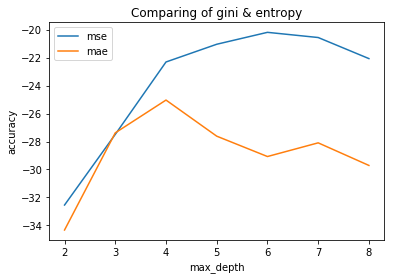

In [209]:
plt.rcParams['figure.figsize'] = (6,4) 

plt.plot(best_treeR.cv_results_["param_max_depth"][:7].astype("float"), 
         best_treeR.cv_results_["mean_test_score"][:7].astype("float"), label="mse")
plt.plot(best_treeR.cv_results_["param_max_depth"][7:].astype("float"), 
         best_treeR.cv_results_["mean_test_score"][7:].astype("float"), label="mae")

plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Comparing of gini & entropy')
plt.legend();

**Выберите верные утверждения:**
1. На отрезке [2, 8] построенные графики не пересекаются.
2. На отрезке [2, 8] построенные графики пересекаются ровно один раз.
3. Оптимальное значение `max_depth` для каждого из критериев достигается на границе отрезка [2, 8].
4. Наилучшее качество при `max_depth` из [2, 8] достигается при использовании критерия `mad_median`.

**Чему равны найденные оптимальные значения параметров `max_depth` и `criterion`?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 5, criterion = 'variance';